# Perturbation experiment

**Goal of the experiment:** silence or randomize one set of coordinates (Cartesian/polar) to see the effects

Potential metrics:
- performance histogram
- % correct
- shift in behavior
- Steps number

## Init

In [1]:
from pathlib import Path
import torch
import torch.optim as optim
import torch.nn as nn
from collections import deque, namedtuple
from tqdm.auto import tqdm

# from utils import make_deterministic, random_choice
from cartesian_polar.agent import EpsilonGreedy, neural_network
from cartesian_polar import utils
from cartesian_polar.environment import CONTEXTS_LABELS, Actions, Cues, DuplicatedCoordsEnv
import cartesian_polar.plotting as viz

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
USE_INTERNAL_STATE = True

## Experiment params

In [4]:
# keep = "cartesian"
keep = "polar"
silence = True
# silence = False

In [5]:
total_episodes = 100

## Load data

In [6]:
save_path = Path(".") / ".." / ".." / "save"
save_path.exists()

True

In [7]:
data_dir = save_path / "2025-06-27_01-34-00_EastWest_perturbate-inputs"
# data_dir = save_path / "2025-06-27_01-34-59_LeftRight_perturbate-inputs"
data_dir.exists()

True

In [8]:
data_path = data_dir / "data.tar"
data_path.exists()

True

In [9]:
model_path = data_dir / "trained-agent-state-0.pt"
model_path.exists()

True

In [10]:
trained_agents_states = list(data_dir.glob("trained-agent-state*.pt"))
trained_agents_states

[PosixPath('../../save/2025-06-27_01-34-00_EastWest_perturbate-inputs/trained-agent-state-0.pt'),
 PosixPath('../../save/2025-06-27_01-34-00_EastWest_perturbate-inputs/trained-agent-state-1.pt'),
 PosixPath('../../save/2025-06-27_01-34-00_EastWest_perturbate-inputs/trained-agent-state-10.pt'),
 PosixPath('../../save/2025-06-27_01-34-00_EastWest_perturbate-inputs/trained-agent-state-11.pt'),
 PosixPath('../../save/2025-06-27_01-34-00_EastWest_perturbate-inputs/trained-agent-state-12.pt'),
 PosixPath('../../save/2025-06-27_01-34-00_EastWest_perturbate-inputs/trained-agent-state-13.pt'),
 PosixPath('../../save/2025-06-27_01-34-00_EastWest_perturbate-inputs/trained-agent-state-14.pt'),
 PosixPath('../../save/2025-06-27_01-34-00_EastWest_perturbate-inputs/trained-agent-state-15.pt'),
 PosixPath('../../save/2025-06-27_01-34-00_EastWest_perturbate-inputs/trained-agent-state-16.pt'),
 PosixPath('../../save/2025-06-27_01-34-00_EastWest_perturbate-inputs/trained-agent-state-17.pt'),
 PosixPath('

In [11]:
len(trained_agents_states)

30

In [12]:
data_dict = torch.load(data_path, weights_only=False, map_location=DEVICE)

# Access individual arrays by their names
p = data_dict["p"]
env = data_dict["env"]
net = data_dict["net"]

## Inference loop

In [13]:
def ablate_state(state, keep, silence=True):
    new_state = state
    if keep == "cartesian":
        idx = torch.arange(start=11, end=21, device=DEVICE)
    elif keep == "polar":
        idx = torch.arange(start=3, end=11, device=DEVICE)
    else:
        raise ValueError("The state to keep can only be either 'polar' or 'cartesian'")
    if silence:
        repl_val = 0
    else:
        if len(state.shape) > 1:
            repl_val = torch.rand((state.shape[0], len(idx)), device=DEVICE)
        else:
            repl_val = torch.rand(len(idx), device=DEVICE)
    if len(state.shape) > 1:
        new_state[:, idx] = repl_val
    else:
        new_state[idx] = repl_val
    return new_state

In [14]:
# state = env.reset()  # Reset the environment
# state = state.clone().float().detach().to(DEVICE)
# state

In [15]:
# ablate_state(state=state, keep=keep, silence=silence)

In [16]:
# state_batch = torch.tile(state, (3,1))
# state_batch

In [17]:
# ablate_state(state=state_batch, keep=keep, silence=silence)

In [18]:
episodes = torch.arange(total_episodes, device=DEVICE).to(dtype=torch.int)
replay_buffer = deque([], maxlen=p.replay_buffer_max_size)

In [19]:
Transition = namedtuple(
    "Transition", ("state", "action", "reward", "next_state", "done")
)

In [20]:
net, _ = neural_network(
    n_observations=p.n_observations,
    n_actions=p.n_actions,
    nHiddenUnits=p.n_hidden_units,
)  # Reset weights

In [21]:
# # Load trained state from data
# trained_state_dict = torch.load(model_path, weights_only=True, map_location=DEVICE)
# net.load_state_dict(trained_state_dict)
# # target_net.load_state_dict(trained_state_dict)

In [22]:
# optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)
explorer = EpsilonGreedy(
    epsilon=p.epsilon_max,
    epsilon_min=p.epsilon_min,
    epsilon_max=p.epsilon_max,
    decay_rate=p.decay_rate,
    epsilon_warmup=p.epsilon_warmup,
)

In [23]:
p.epsilon_min

0.1

In [24]:
explorer.epsilon = 0.2
explorer.epsilon

0.2

In [25]:
n_runs = len(trained_agents_states)
# run = 0
rewards = torch.zeros((total_episodes, n_runs), device=DEVICE)
steps = torch.zeros((total_episodes, n_runs), device=DEVICE)

In [26]:
for run in range(n_runs):  # Run several times to account for stochasticity
    # Load trained state from data
    trained_state_dict = torch.load(trained_agents_states[run], weights_only=True, map_location=DEVICE)
    net.load_state_dict(trained_state_dict)

    for episode in tqdm(
        episodes, desc=f"Run {run + 1}/{n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        state = state.clone().float().detach().to(DEVICE)
        step_count = 0
        done = False
        total_rewards = 0
        loss = torch.ones(1, device=DEVICE) * torch.nan
        
        while not done:
            state_action_values = net(ablate_state(state=state, keep=keep, silence=silence)).to(DEVICE)  # Q(s_t)
            action = explorer.choose_action(
                action_space=env.action_space,
                state=state,
                state_action_values=state_action_values,
            ).item()
        
            # # Record states and actions
            # all_states[run][episode].append(state.cpu())
            # all_actions[run][episode].append(Actions(action).name)
        
            next_state, reward, done = env.step(
                action=action,
                current_state=state,
                use_internal_state=USE_INTERNAL_STATE,
            )
            if USE_INTERNAL_STATE:
                env.current_state = env.conv_flat_duplicated_coords_to_dict(
                    next_state
                )
        
            # Store transition in replay buffer
            # [current_state (2 or 28 x1), action (1x1), next_state (2 or 28 x1),
            # reward (1x1), done (1x1 bool)]
            done = torch.tensor(done, device=DEVICE).unsqueeze(-1)
            replay_buffer.append(
                Transition(
                    state,
                    action,
                    reward,
                    next_state,
                    done,
                )
            )
        
            total_rewards += reward
            step_count += 1
        
            # Move to the next state
            state = next_state
        
            # explorer.epsilon = explorer.update_epsilon(episode)
        #     epsilons.append(explorer.epsilon)
        
        # all_states[run][episode].append(state.cpu())
        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
        # logger.info(
        #     f"Run: {run + 1}/{p.n_runs} - Episode: {episode + 1}/{p.total_episodes}"
        #     f" - Steps: {step_count} - Loss: {loss.item()}"
        #     f" - epsilon: {explorer.epsilon}"
        # )

Run 1/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 2/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 3/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 4/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 5/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 6/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 7/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 8/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 9/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 10/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 11/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 12/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 13/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 14/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 15/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 16/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 17/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 18/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 19/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 20/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 21/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 22/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 23/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 24/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 25/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 26/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 27/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 28/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 29/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Run 30/30 - Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

## Vizualization

In [27]:
rew_steps_df = utils.postprocess_rewards_steps(
    episodes=episodes, n_runs=n_runs, rewards=rewards, steps=steps
)
rew_steps_df

,Episodes,Rewards,Steps
0,0,1.0,63.0
1,1,1.0,344.0
2,2,1.0,22.0
3,3,1.0,49.0
4,4,1.0,36.0
...,...,...,...
2995,95,0.0,73.0
2996,96,0.0,67.0
2997,97,1.0,98.0
2998,98,1.0,48.0


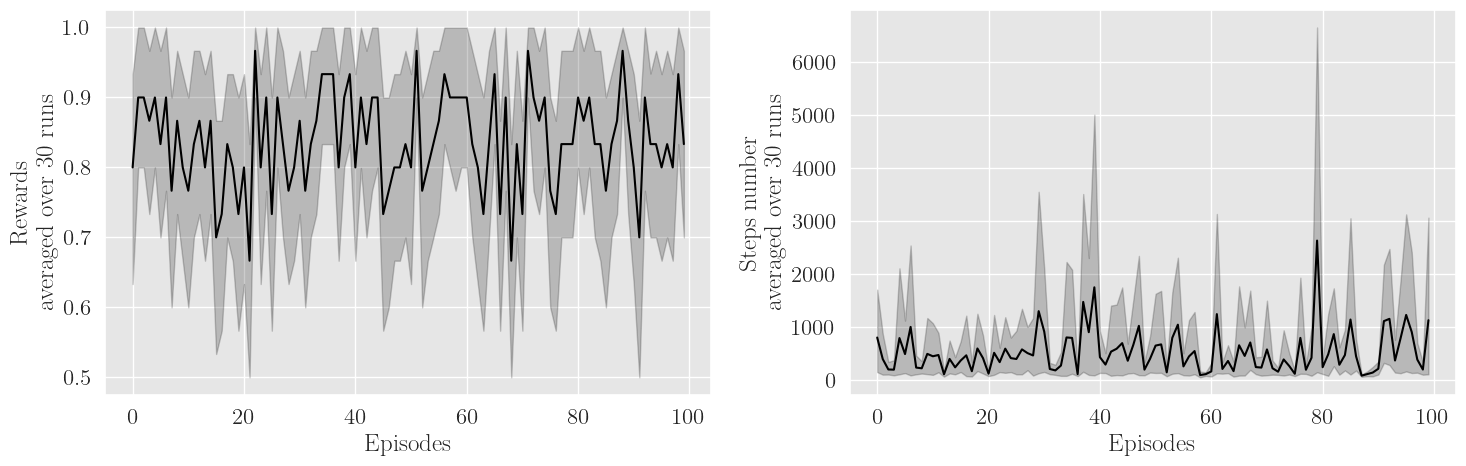

In [28]:
viz.plot_steps_and_rewards(
    rew_steps_df, n_runs=n_runs
)

# Debug

## Initial conditions

In [29]:
explorer.epsilon

0.2

In [30]:
state = env.reset()  # Reset the environment
state = state.clone().float().detach().to(DEVICE)
state

tensor([ 1.0000e+00,  0.0000e+00,  0.0000e+00,  3.0000e+00,  2.0000e+00,
        -1.0000e+00,  4.3711e-08,  1.0000e+00,  2.0000e+00,  1.0000e+00,
        -4.3711e-08,  3.6056e+00,  8.3205e-01,  5.5470e-01, -8.3205e-01,
         5.5470e-01,  2.2361e+00,  4.4721e-01,  8.9443e-01,  4.4721e-01,
        -8.9443e-01])

In [31]:
env.TriangleState

<TriangleState.lower: 2>

In [32]:
env.odor_condition

<OdorCondition.pre: 1>

In [33]:
env.odor_ID

<Cues.OdorA: 1>

## Create tensor

In [34]:
dict_state = env.conv_flat_duplicated_coords_to_dict(state)
Cues(dict_state["cue"].item()), dict_state["direction"], dict_state["x"], dict_state["y"]

(<Cues.NoOdor: 0>, tensor([90.]), tensor([-1.]), tensor([0.]))

In [35]:
dict_state["x"] = torch.tensor([2])
dict_state["y"] = torch.tensor([1])
dict_state["x"], dict_state["y"]

(tensor([2]), tensor([1]))

In [36]:
conv_state = env.conv_dict_to_flat_duplicated_coords(dict_state)
conv_state

tensor([ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
        -1.0000e+00,  4.3711e-08,  4.0000e+00,  3.0000e+00,  1.0000e+00,
        -4.3711e-08,  1.0000e+00, -4.3711e-08,  1.0000e+00,  1.9471e-07,
         1.0000e+00,  5.0000e+00,  8.0000e-01,  6.0000e-01,  8.0000e-01,
        -6.0000e-01])

In [37]:
state_ablated = ablate_state(state=conv_state, keep=keep, silence=silence)
state_ablated

tensor([ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00, -4.3711e-08,  1.0000e+00,  1.9471e-07,
         1.0000e+00,  5.0000e+00,  8.0000e-01,  6.0000e-01,  8.0000e-01,
        -6.0000e-01])

In [38]:
# dict_state_ablated = env.conv_flat_duplicated_coords_to_dict(state_ablated)
# Cues(dict_state_ablated["cue"].item()), dict_state_ablated["direction"], dict_state_ablated["x"], dict_state_ablated["y"]

In [39]:
state_action_values = net(state_ablated).to(DEVICE)  # Q(s_t)
state_action_values

tensor([0.6151, 0.5020, 0.4834], grad_fn=<ViewBackward0>)

In [40]:
Actions(state_action_values.argmax().item())

<Actions.forward: 0>

In [41]:
# action = explorer.choose_action(
#     action_space=env.action_space,
#     state=state,
#     state_action_values=state_action_values,
# ).item()
# action

In [42]:
next_state, reward, done = env.step(action=action, current_state=state)
next_state, reward, done 

(tensor([ 1.0000,  0.0000,  0.0000,  3.0000,  1.0000, -0.0000, -1.0000,  1.0000,
          3.0000,  0.0000,  1.0000,  3.1623,  0.9487,  0.3162, -0.3162, -0.9487,
          3.1623,  0.3162,  0.9487,  0.9487,  0.3162]),
 tensor([0.]),
 False)

In [43]:
dict_next_state = env.conv_flat_duplicated_coords_to_dict(next_state)
Cues(dict_next_state["cue"].item()), dict_next_state["direction"], dict_next_state["x"], dict_next_state["y"]

(<Cues.NoOdor: 0>, tensor([0.]), tensor([-1.]), tensor([1.]))

In [44]:
next_state = ablate_state(state=next_state, keep=keep, silence=silence)
next_state

tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  3.1623,  0.9487,  0.3162, -0.3162, -0.9487,
         3.1623,  0.3162,  0.9487,  0.9487,  0.3162])

In [45]:
# Move to the next state
state = next_state

## Debug loop

In [46]:
explorer.epsilon = 0.5
state = env.reset()  # Reset the environment
state = state.clone().float().detach().to(DEVICE)
print(env.TriangleState)
print(env.odor_ID)

for istep in tqdm(range(10)):
    print(Cues(dict_state["cue"].item()), dict_state["direction"], dict_state["x"], dict_state["y"])
    state_action_values = net(ablate_state(state=state, keep=keep, silence=silence)).to(DEVICE)  # Q(s_t)
    action = explorer.choose_action(
        action_space=env.action_space,
        state=state,
        state_action_values=state_action_values,
    ).item()
    next_state, reward, done = env.step(action=action, current_state=state)

    print(env.odor_condition)
    
    if done:
        print("Done!")
        break

    state = next_state

TriangleState.lower
Cues.OdorB


  0%|          | 0/10 [00:00<?, ?it/s]

Cues.NoOdor tensor([90.]) tensor([2]) tensor([1])
OdorCondition.pre
Cues.NoOdor tensor([90.]) tensor([2]) tensor([1])
OdorCondition.pre
Cues.NoOdor tensor([90.]) tensor([2]) tensor([1])
OdorCondition.pre
Cues.NoOdor tensor([90.]) tensor([2]) tensor([1])
OdorCondition.pre
Cues.NoOdor tensor([90.]) tensor([2]) tensor([1])
OdorCondition.pre
Cues.NoOdor tensor([90.]) tensor([2]) tensor([1])
OdorCondition.pre
Cues.NoOdor tensor([90.]) tensor([2]) tensor([1])
OdorCondition.pre
Cues.NoOdor tensor([90.]) tensor([2]) tensor([1])
OdorCondition.pre
Cues.NoOdor tensor([90.]) tensor([2]) tensor([1])
OdorCondition.pre
Cues.NoOdor tensor([90.]) tensor([2]) tensor([1])
OdorCondition.pre
